In [3]:
from vampyr import vampyr3d as vp
from vampyr import LegendreBasis
#import numpy as np
#import matplotlib.pyplot as plt

We begin by looking at our basis functions, namely, the scaling $\phi_{i,l}^n$ and wavelet $\psi_{i, l}^n$ functions. Where $i$ denotes the order of the polynomial, $l$ denotes the translation and $n$ denotes the scale.

\begin{align}
    \phi_{i, l}^n(x) &= 2^{n/2} \phi_i(2^nx - l) \\
    \psi_{i, l}^n(x) &= 2^{n/2} \psi_i(2^nx - l)
\end{align}

In general we choose or scaling functions to be either [Legendre Polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials) or [Interpolating Polynomials](https://en.wikipedia.org/wiki/Polynomial_interpolation). I'll use Legendre Polynomials here to visualize scaling $\phi$ and wavelet $\psi$ functions.

In [4]:
# Import our basis set
basis = LegendreBasis(5) # This means we have k + 1 basis functions
scaling = basis.scaling
wavelet = basis.wavelet

In [6]:
scaling(0,0,0)([0.0])

1.0

First let's plot our scaling function $\phi_{i, l}^n$ at scale zero. I.e., we plot $\phi_{i, 0}^0$

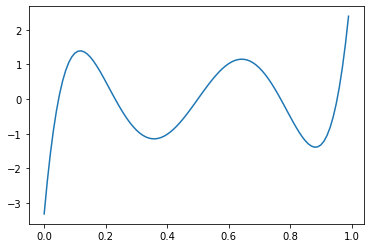

In [20]:
x = np.arange(0.0, 1.0, 0.01)
y = [scaling(i=5, l=0, n=0)([_]) for _ in x]
plt.plot(x, y)

We can also play with the scale $n$ and the translation index $l$

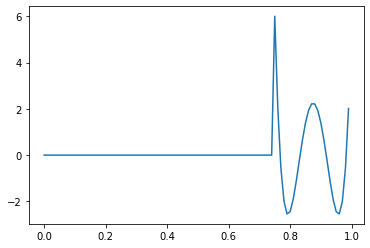

In [26]:
x = np.arange(0.0, 1.0, 0.01)
y = [scaling(i=4, l=3, n=2)([x]) for x in x]
plt.plot(x, y)

Let's plot all of our scaling functions toghether

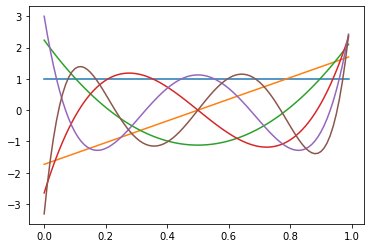

In [29]:
x = np.arange(0.0, 1.0, 0.01)
for i in range(6):
    y = [scaling(i=i, l=0, n=0)([x]) for x in x]
    plt.plot(x, y)